# Forecasting Dengue Fever Challenge

_This notebook was originally created by John Adeojo. Please give credit to the originator if you intend to share this work_

Check out my [professional profile](https://www.john-adeojo.com/)
Want to work with me? Send me a message on [LinkedIn](https://www.linkedin.com/in/john-adeojo/)
This notebook is designed to be read along with the medium article 

_Date last updated: 10/03/2023_

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

# Import data from github

In [2]:
url = 'https://raw.githubusercontent.com/john-adeojo/dengue-model/master/data/01_raw/dengue_features_train.csv'
train_features_df = pd.read_csv(url)

url = 'https://raw.githubusercontent.com/john-adeojo/dengue-model/master/data/01_raw/dengue_features_test.csv'
test_features_df = pd.read_csv(url)

url = 'https://raw.githubusercontent.com/john-adeojo/dengue-model/master/data/01_raw/dengue_labels_train.csv'
train_labels_df = pd.read_csv(url)

# Data Pre-Processing

In [3]:
df = train_features_df.merge(right=train_labels_df, left_on=['city', 'year', 'weekofyear'], right_on=['city', 'year', 'weekofyear'], how='left')
df['week_start_date'] = pd.to_datetime(df['week_start_date'])
test_features_df['week_start_date'] = pd.to_datetime(test_features_df['week_start_date'])

df['weekofyear'] = df['weekofyear'].astype('object')
test_features_df['weekofyear'] = test_features_df['weekofyear'].astype('object')

# Feature Engineering pipeline

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA


class DataProcessor:
    def __init__(self, df_train, df_test, exclude_train, exclude_test, scaling, sj_date_split, iq_date_split):
        self.exclude_train = exclude_train
        self.exclude_test = exclude_test
        self.df_train_in = df_train.copy()
        self.df_test_in = df_test.copy()
        self.sj_date_split = sj_date_split
        self.iq_date_split = iq_date_split
        self.validation_set = None
        self.train_set = None
        self.test_set = None
        self.train_first = None
        self.test_first = None
        self.train_normalised = None
        self.validation_normalised = None
        self.test_normalised = None
        self.scaling = scaling
        self.train_standardised = None
        self.test_standardised = None
        self.validation_standardised = None
        self.train_encoded = None
        self.test_encoded = None
        self.test_encoded_cols = None
        self.train_encoded_cols = None
        self.validation_encoded_cols = None
        self.train_df = None
        self.test_df = None
        self.scaler = StandardScaler()
        self.encoder = OneHotEncoder()
        self.included_cols = None
        self.pca_train = None
        self.pca_test = None
        self.explained_variance_ratio_ = None
        
        
    def add_total_cases_3yr_lag(self):

        df_train_lagged = self.df_train_in.copy()
        df_test_lagged = self.df_test_in.copy()
        
        # construct month variable
        df_train_lagged["month"] = df_train_lagged['week_start_date'].dt.month.astype('object')
        df_test_lagged["month"] = df_test_lagged['week_start_date'].dt.month.astype('object')
        
        # Select the required subset of columns
        subset = df_train_lagged[['month', 'total_cases', 'city', 'year']].copy()
        
        # Create monthly lag features
        subset = subset.groupby(['month', 'city', 'year']).agg(
            {
                'total_cases': ['mean', 'max', 'min']
            }
        ).reset_index()
        
        subset.columns = [f"{col[0]}_{col[1].lower()}" for col in subset.columns]

        subset.rename(columns={'total_cases_mean':'monthly_average_total_cases_3yr_lag',
                               'total_cases_max': 'monthly_max_cases_3yrs_lag',
                               'total_cases_min': 'montly_min_cases_3yrs_lag',
                               'month_':'month',
                               'city_':'city',
                               'year_':'year'
                               
                              }, inplace=True)
        
        subset["year"] = subset['year'] + 3 # create a 3 year lag
        self.subset = subset


        # Perform left merge on train set
        train_merge = df_train_lagged.merge(right=subset, left_on=['city', 'month', 'year'], right_on=['city', 'month', 'year'], how='left', suffixes=('', '_3yr_lag'))

        # Perform left merge on test set
        test_merge = df_test_lagged.merge(right=subset, left_on=['city', 'month', 'year'], right_on=['city', 'month', 'year'], how='left')

        # Return new data sets
        self.df_train_first = train_merge.loc[~train_merge['monthly_average_total_cases_3yr_lag'].isnull()].copy() # retain non-Nan values
        self.df_test_first = test_merge.copy()
        
        
    def validation_split(self):
        # Split out validation set for city 'iq'
        iq_train = self.df_train_first.loc[(self.df_train_first["city"] == 'iq') & (self.df_train_first["week_start_date"] <= self.iq_date_split)]
        iq_validation = self.df_train_first.loc[(self.df_train_first["city"] == 'iq') & (self.df_train_first["week_start_date"] > self.iq_date_split)]

        # Split out validation and train set for city 'sj'
        sj_train = self.df_train_first.loc[(self.df_train_first["city"] == 'sj') & (self.df_train_first["week_start_date"] <= self.sj_date_split)]
        sj_validation = self.df_train_first.loc[(self.df_train_first["city"] == 'sj') & (self.df_train_first["week_start_date"] > self.sj_date_split)]

        # Concatenate the train and validation sets for each city
        self.train_set = pd.concat([iq_train, sj_train], axis=0)
        self.validation_set = pd.concat([iq_validation, sj_validation], axis=0)
        self.test_set = self.df_test_first 
        
        print ("iq train split", iq_train.shape[0]/(iq_validation.shape[0] + iq_train.shape[0]))
        print ("sj train split", sj_train.shape[0]/(sj_validation.shape[0] + sj_train.shape[0]))
        
      
        
    def replace_na(self):
        
        # replace NAs in the training set
        num_cols = self.train_set.select_dtypes(include=['int', 'float']).columns.difference(self.exclude_train)
        means = self.train_set[num_cols].mean()
        self.train_set[num_cols] = self.train_set[num_cols].fillna(means)
        
        
        # replace NAs in the validation set
        num_cols = self.validation_set.select_dtypes(include=['int', 'float']).columns.difference(self.exclude_train)
        means = self.validation_set[num_cols].mean()
        self.validation_set[num_cols] = self.validation_set[num_cols].fillna(means)
        
        # replace NA in the test set 
        num_cols = self.test_set.select_dtypes(include=['int', 'float']).columns.difference(self.exclude_test)
        means = self.test_set[num_cols].mean()
        self.test_set[num_cols] = self.test_set[num_cols].fillna(means)
        
            
    def standardise_or_normalise(self):
        
        if self.scaling == "standardise":
            # standardise numeric variables in train set
            self.train_standardised = self.train_set.copy()
            numeric_cols = self.train_standardised.select_dtypes(include=np.number).columns.drop(["year", "total_cases"])
            self.scaler.fit(self.train_standardised[numeric_cols])
            self.train_standardised[numeric_cols] = self.scaler.transform(self.train_standardised[numeric_cols])

            # standardise numeric variables in validation set 
            self.validation_standardised = self.validation_set.copy()
            self.validation_standardised[numeric_cols] = self.scaler.transform(self.validation_standardised[numeric_cols])

            # standardise numeric variables in test set
            self.test_standardised = self.test_set.copy()
            self.test_standardised[numeric_cols] = self.scaler.transform(self.test_standardised[numeric_cols])
        

        if self.scaling == "normalise":
            # fit scaler on train
            scaler = MinMaxScaler()
            numeric_cols = self.train_set.select_dtypes(include=['int', 'float']).columns.difference(["year", "total_cases"])
            scaler.fit(self.train_set[numeric_cols])

            # normalise train
            self.train_normalise = self.train_set.copy()
            self.train_normalise[numeric_cols] = scaler.transform(self.train_set[numeric_cols])

            # normalise validation
            self.validation_normalise = self.validation_set.copy()
            self.validation_normalise[numeric_cols] = scaler.transform(self.validation_set[numeric_cols])

            # normalise test
            self.test_normalise = self.test_set.copy()
            self.test_normalise[numeric_cols] = scaler.transform(self.test_set[numeric_cols])
    

    
    def onehotencode(self):
        
        if self.scaling == "standardise": 
            _train = self.train_standardised.copy()
            _test = self.test_standardised.copy()
            _validation = self.validation_standardised.copy()
            
        if self.scaling == "normalise":
            _train = self.train_normalise.copy()
            _test = self.test_normalise.copy()
            _validation = self.validation_normalise.copy()
        

        # fit one hot encoder on train set
        train_object_cols = _train.select_dtypes(include='object').columns.difference(['city'])
        self.encoder = OneHotEncoder(handle_unknown='ignore')
        self.encoder.fit(_train[train_object_cols])

        # apply one hot encoding on train set
        self.train_encoded_cols = pd.DataFrame(
            self.encoder.transform(_train[train_object_cols]).toarray(),
            columns=self.encoder.get_feature_names_out(train_object_cols),
            index=_train.index
        )
        
        self.train_encoded = _train.drop(columns=train_object_cols).merge(right=self.train_encoded_cols, how='left', left_index=True, right_index=True)

        # apply one hot encoding on test set
        test_object_cols = _test.select_dtypes(include='object').columns.difference(['city'])
        self.test_encoded_cols = pd.DataFrame(
            self.encoder.transform(_test[test_object_cols]).toarray(),
            columns=self.encoder.get_feature_names_out(test_object_cols),
            index=_test.index
        )
        
        self.test_encoded = _test.drop(columns=test_object_cols).merge(right=self.test_encoded_cols, how='left', left_index=True, right_index=True)

        # apply one hot encoding on validatiom set
        validation_object_cols = _validation.select_dtypes(include='object').columns.difference(['city'])
        self.validation_encoded_cols = pd.DataFrame(
            self.encoder.transform(_validation[validation_object_cols]).toarray(),
            columns=self.encoder.get_feature_names_out(validation_object_cols),
            index=_validation.index
        )
        
        self.validation_encoded = _validation.drop(columns=validation_object_cols).merge(right=self.validation_encoded_cols, how='left', left_index=True, right_index=True)
        
        
        
    def pca(self, n_components):
        
        # apply principle component analysis
        pca = PCA(n_components=n_components)

        # exclude certain columns from PCA
        self.included_cols = [col for col in self.train_encoded.columns if col not in self.exclude_train]
        self.train_df = self.train_encoded[self.exclude_train].copy()
        self.validation_df = self.validation_encoded[self.exclude_train].copy()
        self.test_df = self.test_encoded[self.exclude_test].copy()

        # apply PCA on included columns
        pca.fit(self.train_encoded[self.included_cols])
        self.pca_train = pd.DataFrame(pca.transform(self.train_encoded[self.included_cols]), index=self.train_df.index)
        self.pca_validation = pd.DataFrame(pca.transform(self.validation_encoded[self.included_cols]), index=self.validation_df.index)
        self.pca_test = pd.DataFrame(pca.transform(self.test_encoded[self.included_cols]), index=self.test_df.index)
        
        self.train_df = self.train_df[self.exclude_train].merge(right=self.pca_train, how='left', left_index=True, right_index=True)
        self.validation_df = self.validation_df[self.exclude_train].merge(right=self.pca_validation, how='left', left_index=True, right_index=True)
        self.test_df = self.test_df[self.exclude_test].merge(right=self.pca_test, how='left', left_index=True, right_index=True)        

        print(f"Explained variance: {pca.explained_variance_ratio_}")
        print(f"Explained variance total: {np.sum(pca.explained_variance_ratio_)}")
        
        # self.train_df = self.train_encoded
        # self.validation_df = self.validation_encoded
        # self.test_df = self.test_encoded
    
    def process_data(self, n_components):
        self.add_total_cases_3yr_lag()
        self.validation_split()
        self.replace_na()
        self.standardise_or_normalise()
        self.onehotencode()
        self.pca(n_components)
        self.train_df.sort_values(by="week_start_date", ascending=True, inplace=True)

        return self.train_df, self.validation_df, self.test_df


In [5]:
# running processing pipeline
exclude_train = ["year", "total_cases", "week_start_date", "city"]
exclude_test = ["year", "week_start_date", "city"]
n_components=20

dp = DataProcessor(
    df_train=df, 
    df_test=test_features_df, 
    exclude_test=exclude_test, 
    exclude_train=exclude_train,
    scaling = 'normalise',
    iq_date_split = '2008-09-30',
    sj_date_split = '2004-07-30'
)

train_df, validation_df, test_df = dp.process_data(n_components=56)

iq train split 0.7527472527472527
sj train split 0.7525510204081632
Explained variance: [0.0937375  0.08619867 0.04858202 0.04625616 0.04246143 0.04157703
 0.0404337  0.03873553 0.03847661 0.03777336 0.03574717 0.03563593
 0.02670954 0.01714782 0.01441818 0.01187469 0.00929714 0.00839906
 0.00827286 0.0082369  0.00821087 0.00808147 0.00794835 0.00792781
 0.00785686 0.00782668 0.00782072 0.00781306 0.00779443 0.00779133
 0.00778891 0.00778685 0.00778616 0.00778038 0.00776456 0.00774211
 0.00769529 0.00764154 0.00754659 0.00748238 0.00741662 0.00740956
 0.007385   0.00735881 0.00734809 0.00733867 0.00733419 0.00733284
 0.00733038 0.00732906 0.00732854 0.00732736 0.00729588 0.00704514
 0.00678977 0.00617035]
Explained variance total: 0.9615978965649171


# Model Training

In [6]:
# Helper functions 
import plotly.express as px

def generate_uniform_distribution(min_val, max_val, size=1, seed=19):
    # create a uniform distribution object
    dist = uniform(loc=min_val, scale=max_val-min_val)
    return dist

def plot_joint_distribution(data, var1, var2, title):
    df = pd.DataFrame({var1: data[var1], var2: data[var2] *-1})
    fig = px.scatter(df, x=var1, y=var2, marginal_x="histogram", marginal_y="histogram", title=title)
    fig.show()
    

# def plot_time_series(df, title):
#     #df = pd.DataFrame({'y': y, 'y_hat': y_hat, 'week_start_date': week_start_date})
#     fig = px.line(df, x='week_start_date', y=['total_cases', 'predicted_cases'], title=title,
#                   labels={'value': 'number of dengue cases', 'week_of_year': 'Week of Year'})
#     fig.show()
    
def plot_time_series(df, title):
    # Drop rows with missing values
    df = df.dropna()
    
    # Plot the time series
    fig = px.line(df, x='week_start_date', y=['total_cases', 'predicted_cases'],
                  labels={'week_start_date': 'Date', 'value': 'Total Dengue Cases'},
                  title=title)
    fig.update_traces(name='Actual Cases', selector=dict(name='total_cases'))
    fig.update_traces(name='Forecasted Cases', selector=dict(name='predicted_cases'))
    fig.show()

    


In [7]:
# Set up function for modelling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import mean_absolute_error



def train_model(dataset_dict, estimator, model_name, regularisation, param_distributions):
    

    df_train = dataset_dict.get('train').copy()
    df_validation = dataset_dict.get('validation').copy()
    train_iq = df_train.copy().loc[df_train["city"] == "iq"]
    train_sj = df_train.copy().loc[df_train["city"] == "sj"]
    
    # Set up data sets for modelling - Model for cities iq and sj seprately
    drop_cols = ["total_cases", "week_start_date", "year", "city"]
    X_train_iq = train_iq.drop(columns=drop_cols)
    y_train_iq = train_iq["total_cases"]
    X_train_sj = train_sj.drop(columns=drop_cols)
    y_train_sj = train_sj["total_cases"]

    # Prediction data: combines test and validation for plotting time series.
    prediction_set = pd.concat([df_validation, df_train], axis=0, ignore_index=False)
    prediction_set_iq = prediction_set.copy().loc[prediction_set["city"]=='iq']
    prediction_set_sj = prediction_set.copy().loc[prediction_set["city"]=='sj']
    
    prediction_set_iq.sort_values(by='week_start_date', ascending=True, inplace=True)
    prediction_set_sj.sort_values(by='week_start_date', ascending=True, inplace=True)
    
    X_predict_iq = prediction_set_iq.drop(columns=drop_cols)
    X_predict_sj = prediction_set_sj.drop(columns=drop_cols)
    
    # Validation sets:
    validation_set_iq = df_validation.copy().loc[df_validation["city"]=='iq']
    validation_set_sj = df_validation.copy().loc[df_validation["city"]=='sj']
    
    X_validation_iq = validation_set_iq.drop(columns=drop_cols)
    X_validation_sj = validation_set_sj.drop(columns=drop_cols)
    
    y_validation_actual_iq = validation_set_iq['total_cases']
    y_validation_actual_sj = validation_set_sj['total_cases']
    
    
    args={
    "n_splits":5
    # "test_size":150,
    # "gap": 50,
    # "max_train_size":1000
    }

    random_search_kwargs = {
        "estimator": estimator,
        "param_distributions": param_distributions,
        "n_iter": 500,
        "scoring": "neg_mean_absolute_error",
        "cv": TimeSeriesSplit(**args)
        # "cv": 1

    }

    # Train model for iq
    train_model_iq = RandomizedSearchCV(**random_search_kwargs)
    train_model_iq.fit(X_train_iq, y_train_iq)

    # Train model for sj
    train_model_sj = RandomizedSearchCV(**random_search_kwargs)
    train_model_sj.fit(X_train_sj, y_train_sj)

    # Output fit metrics 
    data = train_model_iq.cv_results_
    var1 = f"param_{regularisation}"
    var2 = "mean_test_score"
    title= f" Iq {model_name}: Param vs std MAE"
    plot_joint_distribution(data, var1, var2, title)
    
    # Output fit metrics 
    data = train_model_sj.cv_results_
    var1 = f"param_{regularisation}"
    var2 = "mean_test_score"
    title= f" Sj {model_name}: Param vs std MAE"
    plot_joint_distribution(data, var1, var2, title)
    
    # print MAE
    y_pred = train_model_iq.predict(X_validation_iq)
    y_true = y_validation_actual_iq
    mae = mean_absolute_error(y_true, y_pred)
    print('Validation set: Mean Absolute Error Iq:', mae)
    
    y_pred = train_model_sj.predict(X_validation_sj)
    y_true = y_validation_actual_sj
    mae = mean_absolute_error(y_true, y_pred)
    print('Validation set: Mean Absolute Error Sj:', mae)

    # Visualise Model against past data     
    prediction_set_iq["predicted_cases"] = train_model_iq.predict(X_predict_iq)
    prediction_set_sj["predicted_cases"] = train_model_sj.predict(X_predict_sj)
    
    plot_time_series(df=prediction_set_iq, title=f"{model_name} Iq actuals vs model")
    plot_time_series(df=prediction_set_sj, title=f"{model_name} Sj actuals vs model")
    
    return train_model_iq, train_model_sj
         

# Ridge Regressor

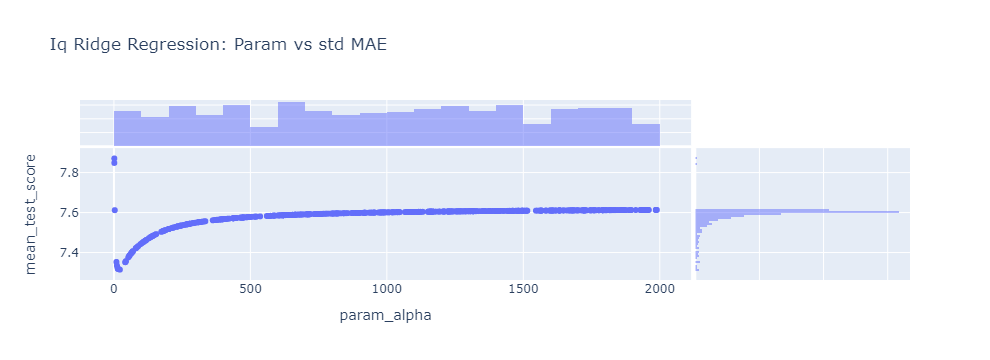

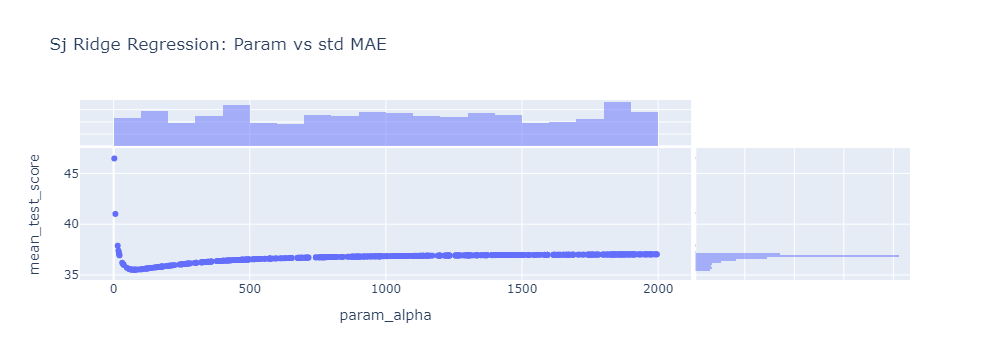

Validation set: Mean Absolute Error Iq: 6.709424415304009
Validation set: Mean Absolute Error Sj: 23.211080442935163


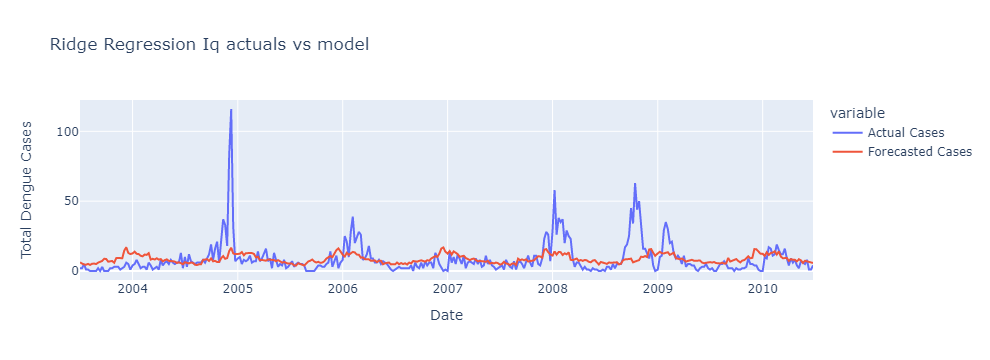

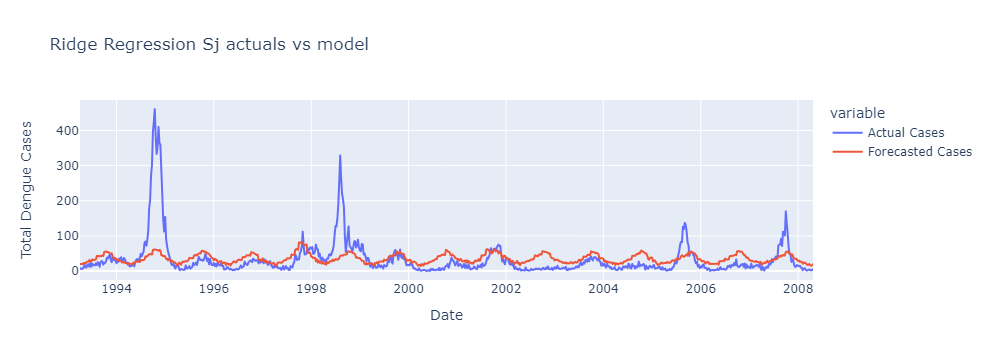

In [8]:
from sklearn.linear_model import Ridge

dataset_dict = {
    'train': train_df,
    'validation': validation_df
}

esitmator = Ridge()
model_name = 'Ridge Regression'
regularisation = 'alpha'
param_distributions = {regularisation: generate_uniform_distribution(min_val=1, max_val=2000)}

ridge_model_iq, ridge_model_sj = train_model(
    dataset_dict=dataset_dict, 
    estimator=esitmator, 
    model_name=model_name, 
    regularisation=regularisation,
    param_distributions=param_distributions
)

# XGBoost Regressor: with Poission objective

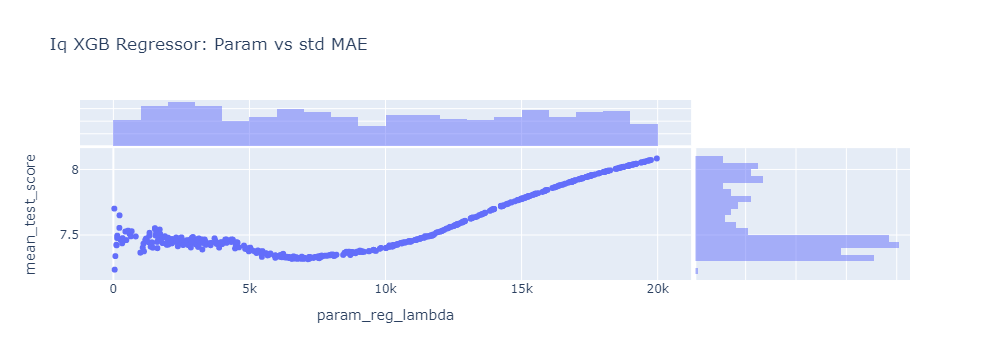

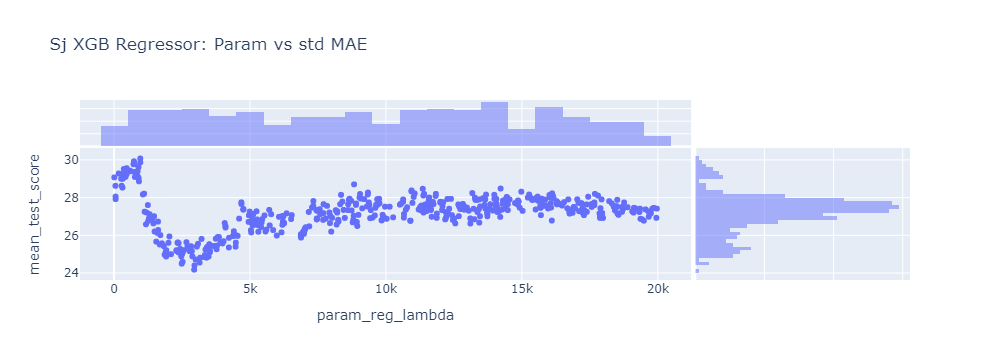

Validation set: Mean Absolute Error Iq: 6.774292696515719
Validation set: Mean Absolute Error Sj: 19.870804073884315


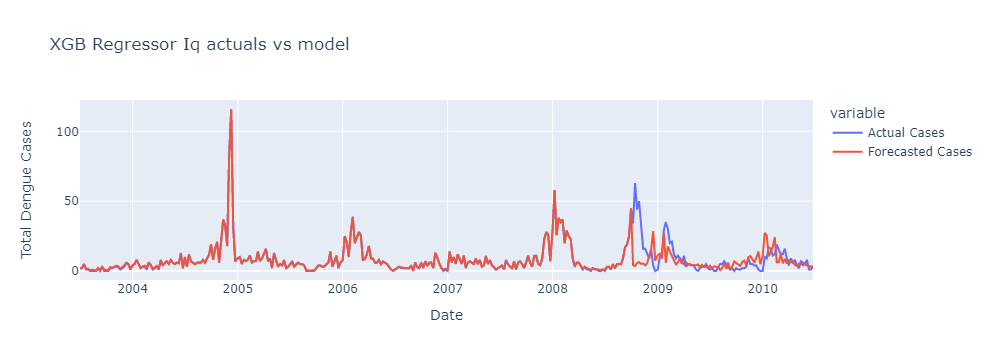

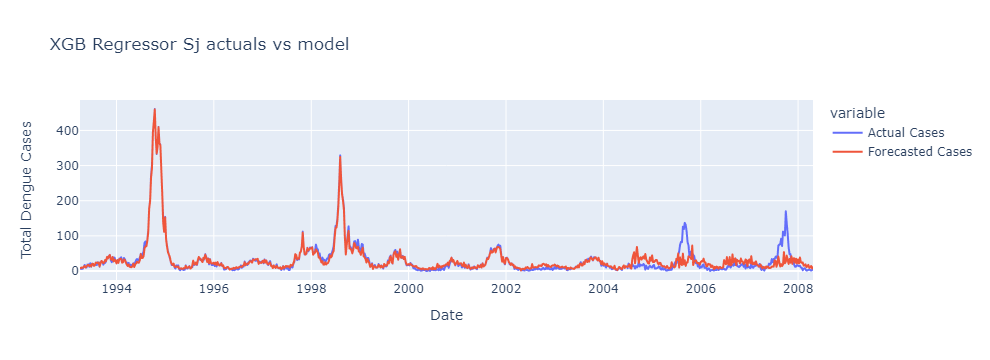

In [9]:
from xgboost import XGBRegressor

dataset_dict = {
    'train': train_df,
    'validation': validation_df
}

esitmator = XGBRegressor(objective='count:poisson')
model_name = 'XGB Regressor'
regularisation = 'reg_lambda'
param_distributions = {regularisation: generate_uniform_distribution(min_val=1, max_val=20000)}

poission_xgb_model_iq, poission_xgb_model_sj = train_model(
    dataset_dict=dataset_dict, 
    estimator=esitmator, 
    model_name=model_name, 
    regularisation=regularisation,
    param_distributions=param_distributions
)

# XGBoost Regressor: with absolute error objective

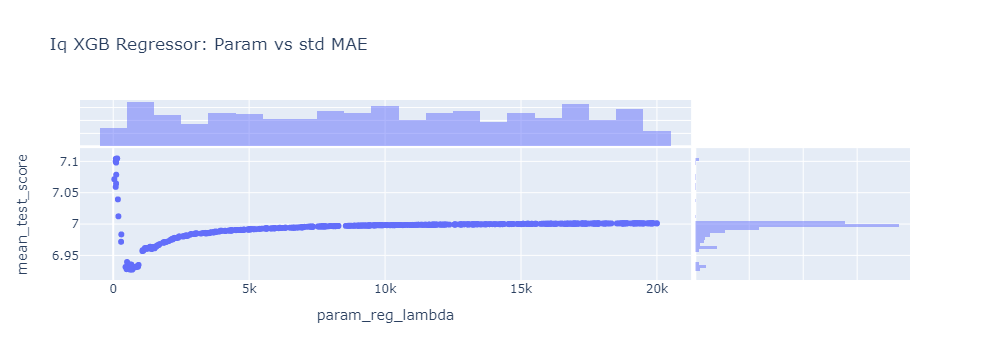

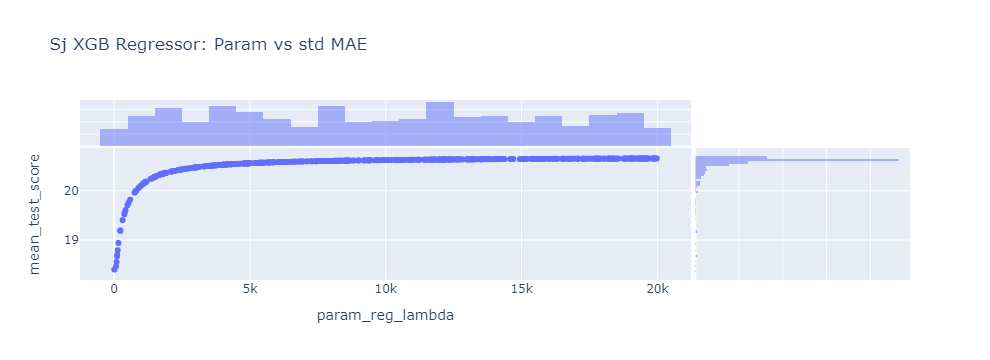

Validation set: Mean Absolute Error Iq: 6.591825522316826
Validation set: Mean Absolute Error Sj: 17.86504868379573


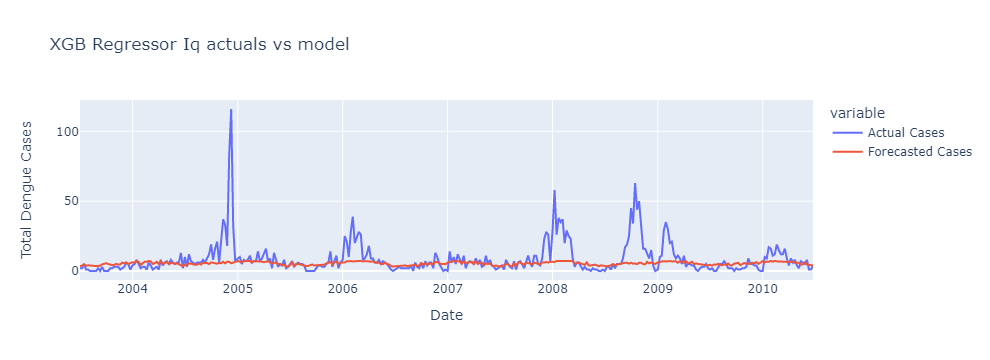

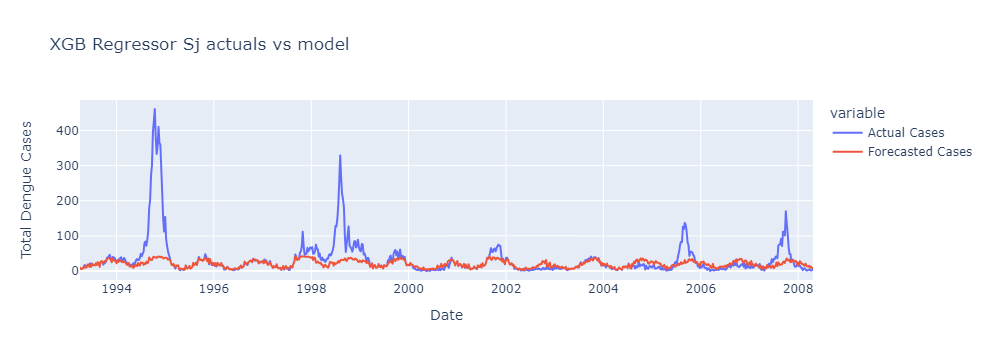

In [10]:
dataset_dict = {
    'train': train_df,
    'validation': validation_df
}

esitmator = XGBRegressor(objective='reg:absoluteerror')
model_name = 'XGB Regressor'
regularisation = 'reg_lambda'
param_distributions = {regularisation: generate_uniform_distribution(min_val=1, max_val=20000)}

abs_xgb_model_iq, abs_xgb_model_sj = train_model(
    dataset_dict=dataset_dict, 
    estimator=esitmator, 
    model_name=model_name, 
    regularisation=regularisation,
    param_distributions=param_distributions
)

# XGBoost Regressor: with squaredlogerror error objective

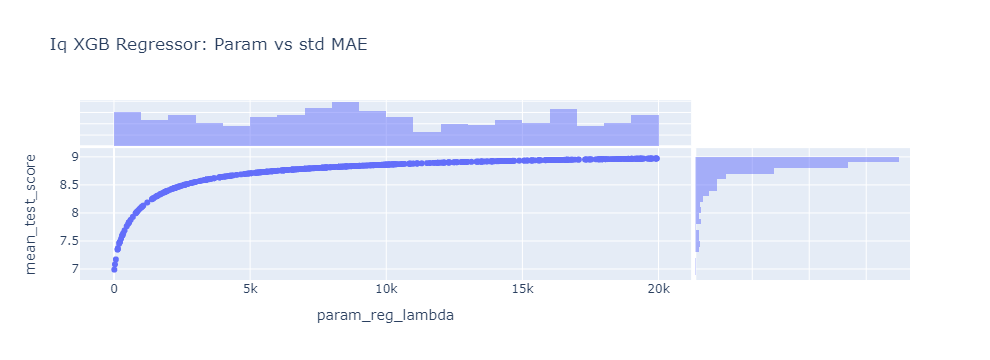

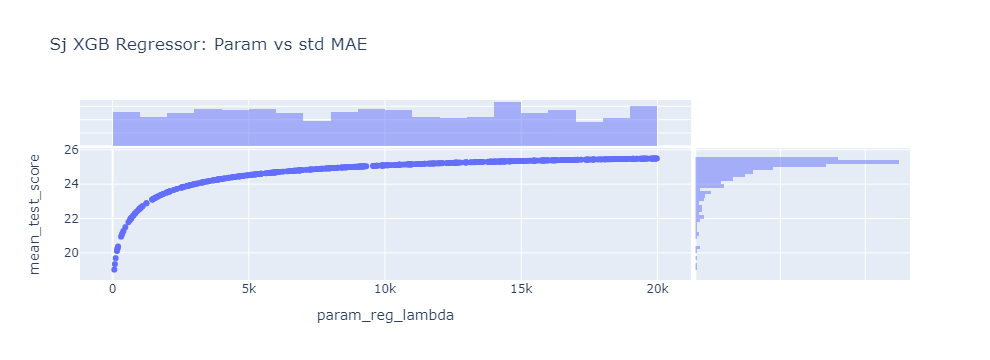

Validation set: Mean Absolute Error Iq: 6.2814408487743805
Validation set: Mean Absolute Error Sj: 16.800882039610872


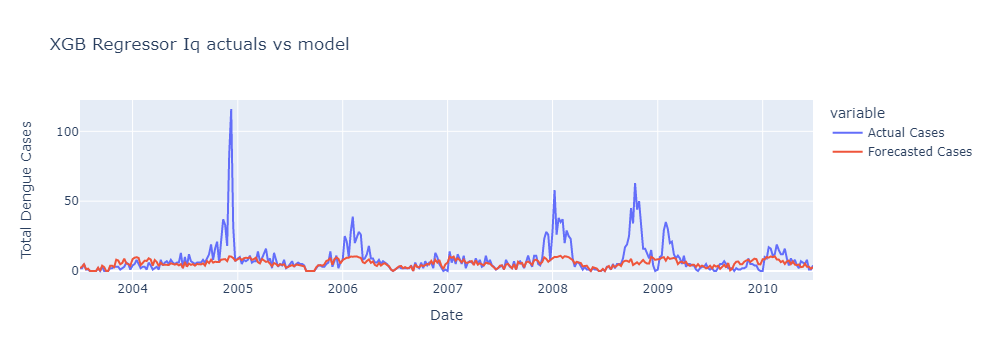

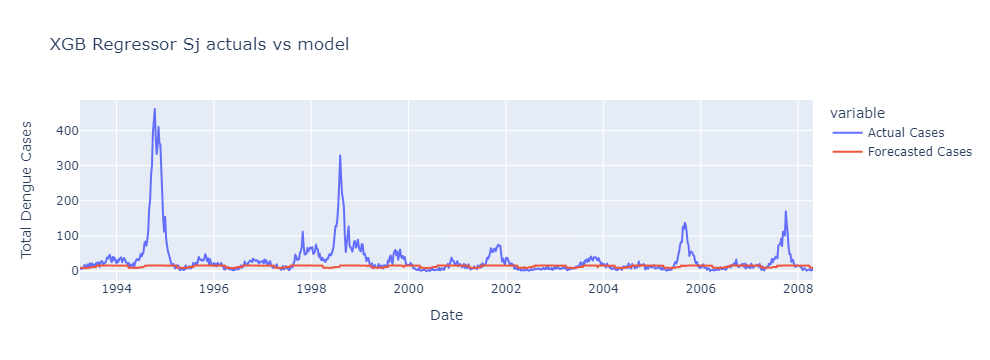

In [11]:
dataset_dict = {
    'train': train_df,
    'validation': validation_df
}

esitmator = XGBRegressor(objective='reg:squaredlogerror')
model_name = 'XGB Regressor'
regularisation = 'reg_lambda'
param_distributions = {regularisation: generate_uniform_distribution(min_val=1, max_val=20000)}

sqlog_xgb_model_iq, sqlog_xgb_model_sj = train_model(
    dataset_dict=dataset_dict, 
    estimator=esitmator, 
    model_name=model_name, 
    regularisation=regularisation,
    param_distributions=param_distributions
)

# XGBoost Regressor: with pseudohubererror error objective

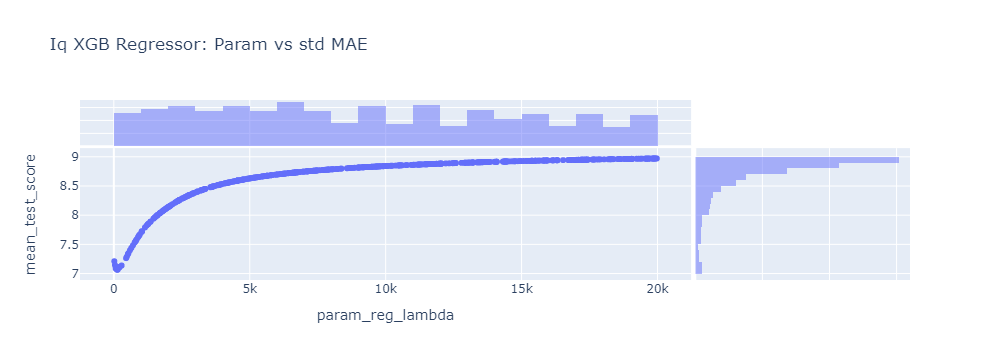

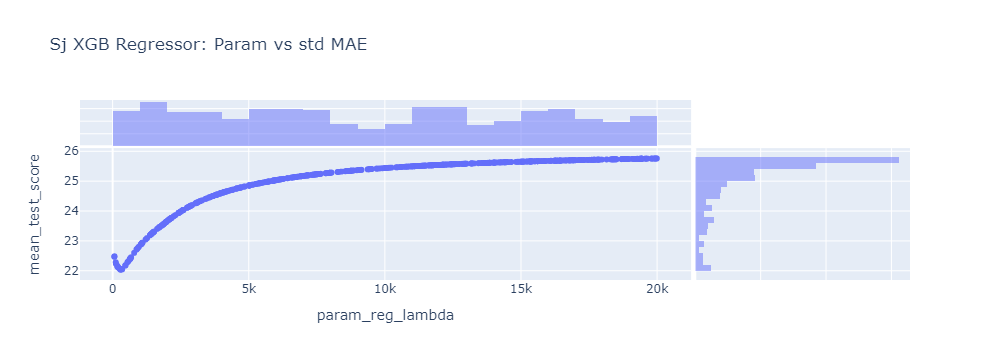

Validation set: Mean Absolute Error Iq: 6.315670881668726
Validation set: Mean Absolute Error Sj: 17.610402920811445


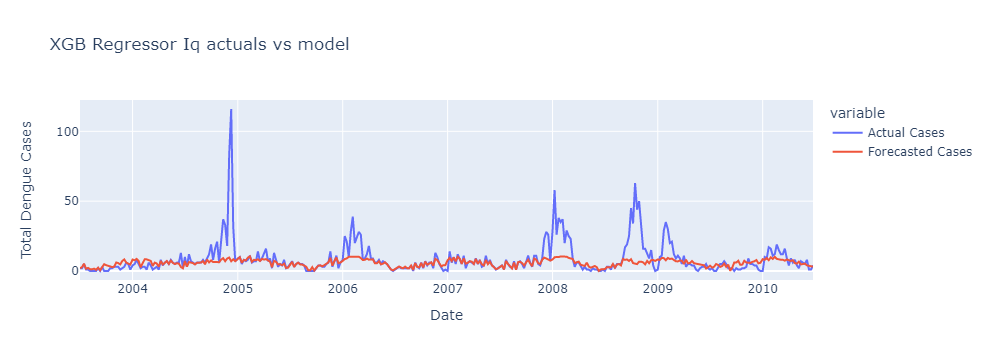

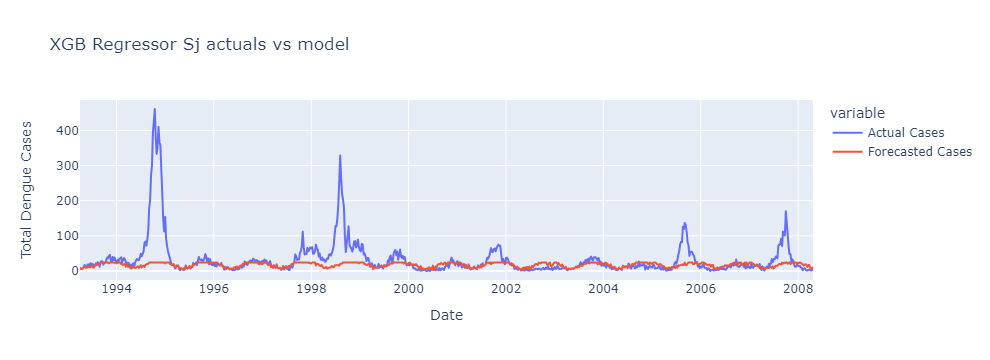

In [12]:
dataset_dict = {
    'train': train_df,
    'validation': validation_df
}

esitmator = XGBRegressor(objective='reg:pseudohubererror')
model_name = 'XGB Regressor'
regularisation = 'reg_lambda'
param_distributions = {regularisation: generate_uniform_distribution(min_val=1, max_val=20000)}

hub_xgb_model_iq, hub_xgb_model_sj = train_model(
    dataset_dict=dataset_dict, 
    estimator=esitmator, 
    model_name=model_name, 
    regularisation=regularisation,
    param_distributions=param_distributions
)

In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import plotly.express as px

args={
    "n_splits":5
    # "test_size":150,
    # "gap": 50,
    # "max_train_size":1000
}

random_search_kwargs = {
    "estimator": Ridge(),
    "param_distributions": {"alpha": generate_uniform_distribution(min_val=1, max_val=2000)},
    "n_iter": 500,
    "scoring": "neg_mean_absolute_error",
    "cv": TimeSeriesSplit(**args)
    # "cv": 1

}

train_model = RandomizedSearchCV(**random_search_kwargs)
ridge_regressor = train_model.fit(X_train, y_train)


# Output fit metrics 
data = ridge_regressor.cv_results_
var1 = "param_alpha"
var2 = "mean_test_score"
title= f"{model_name}: Param vs std MAE"
plot_joint_distribution(data, var1, var2, title)

NameError: name 'X_train' is not defined

In [ ]:
# Visualise Model against past data 
df_ridge = df_lagged_subset.copy()
df_ridge["predicted_cases"] = ridge_regressor.predict(X_predict)
df_iq = df_ridge.loc[df_ridge['city'] =="iq"]
df_sj = df_ridge.loc[df_ridge['city'] =="sj"]

 
plot_time_series(df=df_iq, title="Iq actuals vs model")
plot_time_series(df=df_sj, title="Sj actuals vs model")

In [ ]:
from xgboost import XGBRegressor
random_search_kwargs = {
    "estimator": XGBRegressor(n_jobs=4, objective='count:poisson'),
    "param_distributions": {"reg_lambda": generate_uniform_distribution(min_val=5000, max_val=100000)},
    "n_iter": 500,
    "scoring": "neg_mean_absolute_error",
    "cv": TimeSeriesSplit(**args) 
}

train_model = RandomizedSearchCV(**random_search_kwargs)

xgboost_regressor = train_model.fit(X_train, y_train)

# visualise model fit
data = xgboost_regressor.cv_results_
var1 = "param_reg_lambda"
var2 = "mean_test_score"
title= "XGBRegressor: Param vs std MAE"
plot_joint_distribution(data, var1, var2, title)

In [ ]:
# Visualise Model against past data 
df_xgb = df_lagged_subset.copy()
df_xgb["predicted_cases"] = xgboost_regressor.predict(X_predict)
df_iq = df_xgb.loc[df_xgb['city'] =="iq"]
df_sj = df_xgb.loc[df_xgb['city'] =="sj"]


plot_time_series(df=df_iq, title="XGBoost: Iq actuals vs model")
plot_time_series(df=df_sj, title="XGBoost: Sj actuals vs model")

# Model Prediction

In [ ]:
# Predict on Test
remove = ["week_start_date", "year", "weekofyear_binned"]
X_test = model_features(train_df=test_engineered_df, remove=remove)
y_hat = np.round(np.maximum(xgboost_random_search.predict(X_test),0)).astype(int)
submission = test_features_df[["city", "year", "weekofyear"]].copy()
submission["total_cases"] = y_hat
submission.head()

In [ ]:
# submission.to_csv("/home/data-scientist/anaconda3/envs/dengue-environment/Dengue Fever Modelling/Submission/submission.csv", index=False)

In [ ]:
end_time = time.time()
elapsed_time_minutes = (end_time - start_time) / 60.0
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")